# HJCFIT- maximum likelihood fit of single-channel data: a simple example

Some general settings:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import sys, time, math
import numpy as np
from numpy import linalg as nplin

### Load data

HJCFIT depends on DCPROGS/DCPYPS module for data input and setting kinetic mechanism:

In [3]:
from dcpyps.samples import samples
from dcpyps import dataset, mechanism, dcplots

In [4]:
fname = "CH82.scn" # binary SCN file containing simulated idealised single-channel open/shut intervals
tr = 1e-4 # temporal resolution to be imposed to the record
tc = 4e-3 # critical time interval to cut the record into bursts
conc = 100e-9 # agonist concentration 


Initialise Single-Channel Record from dcpyps. Note that SCRecord takes a list of file names; several SCN files from the same patch can be loaded.

In [5]:
# Initaialise SCRecord instance.
rec = dataset.SCRecord([fname], conc, tres=tr, tcrit=tc)
rec.printout()



 Data loaded from file: CH82.scn
Concentration of agonist = 0.100 microMolar
Resolution for HJC calculations = 100.0 microseconds
Critical gap length to define end of group (tcrit) = 4.000 milliseconds
	(defined so that all openings in a group prob come from same channel)
Initial and final vectors for bursts calculated asin Colquhoun, Hawkes & Srodzinski, (1996, eqs 5.8, 5.11).

Number of resolved intervals = 1672
Number of resolved periods = 1672

Number of open periods = 836
Mean and SD of open periods = 5.703315580 +/- 6.217026586 ms
Range of open periods from 0.101663936 ms to 36.745440215 ms

Number of shut intervals = 836
Mean and SD of shut periods = 2843.529462814 +/- 3982.407808304 ms
Range of shut periods from 0.100163714 ms to 30754.167556763 ms
Last shut period = 3821.345090866 ms

Number of bursts = 572
Average length = 8.425049759 ms
Range: 0.102 to 62.906 millisec
Average number of openings= 1.461538462


Plot dwell-time histograms for inspection. In single-channel analysis field it is common to plot these histograms with x-axis in log scale and y-axis in square-root scale. After such transformation exponential pdf has a bell-shaped form.

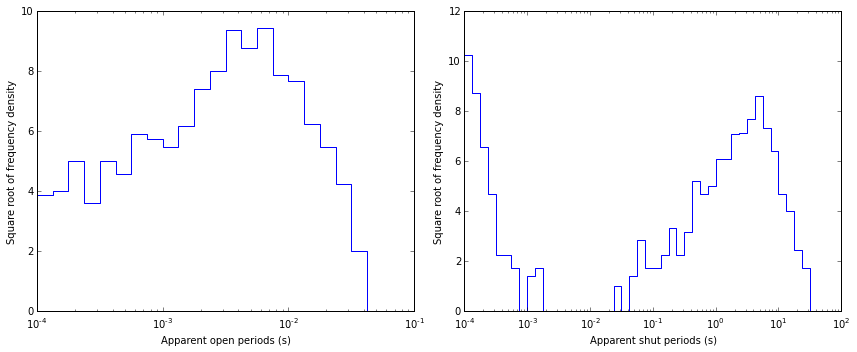

In [6]:
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(121)
dcplots.xlog_hist_data(ax1, rec.opint, rec.tres, shut=False)

ax2 = fig.add_subplot(122)
dcplots.xlog_hist_data(ax2, rec.shint, rec.tres)

fig.tight_layout()

### Load demo mechanism (C&H82 numerical example)

In [7]:
mec = samples.CH82()
mec.printout()


class dcpyps.Mechanism
Values of unit rates [1/sec]:
0	From AR  	to AR*    	beta1   	15.0
1	From A2R  	to A2R*    	beta2   	15000.0
2	From AR*  	to AR    	alpha1   	3000.0
3	From A2R*  	to A2R    	alpha2   	500.0
4	From AR  	to R    	k(-1)   	2000.0
5	From A2R  	to AR    	2k(-2)   	4000.0
6	From R  	to AR    	2k(+1)   	100000000.0
7	From AR*  	to A2R*    	k*(+2)   	500000000.0
8	From AR  	to A2R    	k(+2)   	500000000.0
9	From A2R*  	to AR*    	2k*(-2)   	0.66667

Conductance of state AR* (pS)  =      60

Conductance of state A2R* (pS)  =      60

Number of open states = 2
Number of short-lived shut states (within burst) = 2
Number of long-lived shut states (between bursts) = 1
Number of desensitised states = 0

Number of cycles = 1
Cycle 0 is formed of states: A2R*  AR*  AR  A2R  
	forward product = 1.500007500e+16
	backward product = 1.500000000e+16

In [8]:
# PREPARE RATE CONSTANTS.
# Fixed rates
mec.Rates[7].fixed = True
# Constrained rates
mec.Rates[5].is_constrained = True
mec.Rates[5].constrain_func = mechanism.constrain_rate_multiple
mec.Rates[5].constrain_args = [4, 2]
mec.Rates[6].is_constrained = True
mec.Rates[6].constrain_func = mechanism.constrain_rate_multiple
mec.Rates[6].constrain_args = [8, 2]
# Rates constrained by microscopic reversibility
mec.set_mr(True, 9, 0)
# Update rates
mec.update_constrains()

In [9]:
#Propose initial guesses different from recorded ones 
#initial_guesses = [100, 3000, 10000, 100, 1000, 1000, 1e+7, 5e+7, 6e+7, 10]
initial_guesses = mec.unit_rates()
mec.set_rateconstants(initial_guesses)
mec.update_constrains()
mec.printout()


class dcpyps.Mechanism
Values of unit rates [1/sec]:
0	From AR  	to AR*    	beta1   	15.0
1	From A2R  	to A2R*    	beta2   	15000.0
2	From AR*  	to AR    	alpha1   	3000.0
3	From A2R*  	to A2R    	alpha2   	500.0
4	From AR  	to R    	k(-1)   	2000.0
5	From A2R  	to AR    	2k(-2)   	4000.0
6	From R  	to AR    	2k(+1)   	1000000000.0
7	From AR*  	to A2R*    	k*(+2)   	500000000.0
8	From AR  	to A2R    	k(+2)   	500000000.0
9	From A2R*  	to AR*    	2k*(-2)   	0.666666666667

Conductance of state AR* (pS)  =      60

Conductance of state A2R* (pS)  =      60

Number of open states = 2
Number of short-lived shut states (within burst) = 2
Number of long-lived shut states (between bursts) = 1
Number of desensitised states = 0

Number of cycles = 1
Cycle 0 is formed of states: A2R*  AR*  AR  A2R  
	forward product = 1.500000000e+16
	backward product = 1.500000000e+16

In [10]:
# Extract free parameters
theta = mec.theta()
print ('\ntheta=', theta)


theta= [  1.50000000e+01   1.50000000e+04   3.00000000e+03   5.00000000e+02
   2.00000000e+03   5.00000000e+08]


### Prepare likelihood function

In [11]:
def dcprogslik(x, lik, m, c):
    m.theta_unsqueeze(np.exp(x))
    l = 0
    for i in range(len(c)):
        m.set_eff('c', c[i])
        l += lik[i](m.Q)
    return -l * math.log(10)

In [12]:
# Import HJCFIT likelihood function
from dcprogs.likelihood import Log10Likelihood

# Get bursts from the record
bursts = rec.bursts.intervals()
# Initiate likelihood function with bursts, number of open states,
# temporal resolution and critical time interval
likelihood = Log10Likelihood(bursts, mec.kA, tr, tc)

In [13]:
lik = dcprogslik(np.log(theta), [likelihood], mec, [conc])
print ("\nInitial likelihood = {0:.6f}".format(-lik))


Initial likelihood = 5264.414344


### Run optimisation

In [14]:
from scipy.optimize import minimize
print ("\nScyPy.minimize (Nelder-Mead) Fitting started: " +
       "%4d/%02d/%02d %02d:%02d:%02d"%time.localtime()[0:6])
start = time.clock()
start_wall = time.time()
result = minimize(dcprogslik, np.log(theta), args=([likelihood], mec, [conc]),
               method='Nelder-Mead')
t3 = time.clock() - start
t3_wall = time.time() - start_wall
print ("\nScyPy.minimize (Nelder-Mead) Fitting finished: " +
       "%4d/%02d/%02d %02d:%02d:%02d"%time.localtime()[0:6])
print ('\nCPU time in ScyPy.minimize (Nelder-Mead)=', t3)
print ('Wall clock time in ScyPy.minimize (Nelder-Mead)=', t3_wall)
print ('\nResult   ==========================================\n', result)


ScyPy.minimize (Nelder-Mead) Fitting started: 2016/03/10 12:10:30

ScyPy.minimize (Nelder-Mead) Fitting finished: 2016/03/10 12:10:31

CPU time in ScyPy.minimize (Nelder-Mead)= 0.856413275422394
Wall clock time in ScyPy.minimize (Nelder-Mead)= 0.8570489883422852

Result   ==========================================
   status: 0
 message: 'Optimization terminated successfully.'
    nfev: 415
       x: array([  2.33189798,   9.48999371,   8.20461943,   6.05142787,
         7.68244318,  19.98586637])
     nit: 256
     fun: -5268.5914092352814
 success: True


In [15]:
print ("\nFinal likelihood = {0:.16f}".format(-result.fun))
mec.theta_unsqueeze(np.exp(result.x))
print ("\nFinal rate constants:")
mec.printout()


Final likelihood = 5268.5914092352813896

Final rate constants:

class dcpyps.Mechanism
Values of unit rates [1/sec]:
0	From AR  	to AR*    	beta1   	10.2974673884
1	From A2R  	to A2R*    	beta2   	13226.7121605
2	From AR*  	to AR    	alpha1   	3657.80834791
3	From A2R*  	to A2R    	alpha2   	424.719039018
4	From AR  	to R    	k(-1)   	2169.9147908
5	From A2R  	to AR    	2k(-2)   	4339.82958159
6	From R  	to AR    	2k(+1)   	956712565.145
7	From AR*  	to A2R*    	k*(+2)   	500000000.0
8	From AR  	to A2R    	k(+2)   	478356282.573
9	From A2R*  	to AR*    	2k*(-2)   	0.410062923425

Conductance of state AR* (pS)  =      60

Conductance of state A2R* (pS)  =      60

Number of open states = 2
Number of short-lived shut states (within burst) = 2
Number of long-lived shut states (between bursts) = 1
Number of desensitised states = 0

Number of cycles = 1
Cycle 0 is formed of states: A2R*  AR*  AR  A2R  
	forward product = 9.490188419e+15
	backward product = 9.490188419e+15

### Plot experimental histograms and predicted pdfs

In [16]:
from dcprogs.likelihood import QMatrix
from dcprogs.likelihood import missed_events_pdf, ideal_pdf, IdealG, eig
qmatrix = QMatrix(mec.Q, 2)
idealG = IdealG(qmatrix)

Note that to properly overlay ideal and missed-event corrected pdfs ideal pdf has to be scaled (need to renormailse to 1 the area under pdf from $\tau_{res}$). 

In [18]:
# Scale for ideal pdf
def scalefac(tres, matrix, phiA):
    eigs, M = eig(-matrix)
    N = nplin.inv(M)
    k = N.shape[0]
    A = np.zeros((k, k, k))
    for i in range(k):
        A[i] = np.dot(M[:, i].reshape(k, 1), N[i].reshape(1, k))
    w = np.zeros(k)
    for i in range(k):
        w[i] = np.dot(np.dot(np.dot(phiA, A[i]), (-matrix)), np.ones((k, 1)))
    return 1 / np.sum((w / eigs) * np.exp(-tres * eigs))

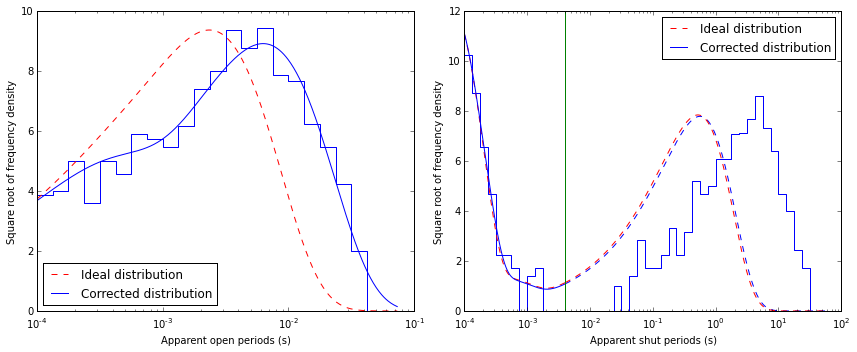

In [19]:
fig = plt.figure(figsize=(12,5))

# Plot apparent open period histogram
ax1 = fig.add_subplot(121)
ipdf = ideal_pdf(qmatrix, shut=False) 
iscale = scalefac(tr, qmatrix.aa, idealG.initial_occupancies)
epdf = missed_events_pdf(qmatrix, tr, nmax=2, shut=False)
dcplots.xlog_hist_HJC_fit(ax1, rec.tres, rec.opint, epdf, ipdf, iscale, shut=False)

# Plot apparent shut period histogram
ax2 = fig.add_subplot(122)
ipdf = ideal_pdf(qmatrix, shut=True)
iscale = scalefac(tr, qmatrix.ff, idealG.final_occupancies)
epdf = missed_events_pdf(qmatrix, tr, nmax=2, shut=True)
dcplots.xlog_hist_HJC_fit(ax2, rec.tres, rec.shint, epdf, ipdf, iscale, tcrit=rec.tcrit)

fig.tight_layout()

Note that in this record only shut time intervals shorter than critical time ($t_{crit}$) were used to minimise likelihood. Thus, only a part of shut time histrogram (to the left from green line, indicating $t_{crit}$ value, in the above plot) is predicted well by rate constant estimates.